* implement prony-iir that calculates iir coefficients
* test with synthetic data
* implement denoising step - cadzow or something
* test with synthetic data + awgn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, copy
from numpy.fft import fft, rfft, ifft, irfft, fftfreq, rfftfreq
import scipy as sp
import scipy.signal as signal
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def h_model(N, a, d, T, phi):
    """Signal model: h[n] = \sum_{i=1}^I a_i 2^{-n/d_i} \cos(2\pi n / T_i + \phi_i)"""
    I = len(a)
    h = np.zeros(N)
    n = np.arange(N)
    for i in range(I):
        h += a[i] * np.power(2, -n / d[i]) * np.cos(2*np.pi*n / T[i] + phi[i])
    return h

def pretty_print_hrparams(a, d, T, phi):
    # print in scientific notation
    arr2scistr = lambda x: np.array2string(x, formatter={'float_kind':lambda x: f'{x:.2e}'}, separator=', ')
    arr2str = lambda x, p: np.array2string(x, precision=p, separator=', ')
    print("a: ", arr2scistr(a))
    print("d: ", arr2str(d, 1))
    print("T: ", arr2str(T, 1))
    print("ϕ: ", np.array2string(np.rad2deg(phi), separator=', ', formatter={'rad2deg':lambda x: f'{x:.1f}°'}))

In [4]:
def conj_pairs_idxs(arr: np.ndarray, tol=1e-5, already_sorted=False):
    """Function to find the indices conjugate pairs present in an array of complex numbers. Also returns indices of purely real values, and values not part of any conjugate pair. The 2nd item in the tuple returned is are the indices of positive conjugates, i.e. those numbers part of a conjugate pair whose imaginary part is positive. The 3rd item is the indices of negative conjugates.

    Args:
        arr (np.ndarray): Array in which to find conjugate pairs.
        tol (float, optional): Absolute tolerance for checking both if value is purely real and for checking equality with conjugate. Defaults to 1e-5.
        already_sorted (bool, optional): Set true only if arr is sorted in ascending order by complex magnitude. Defaults to False.

    Returns:
        List, List, List, List: Lists containing indices of purely real, positive conjugates, negative conjugates, and no conjugates respectively.
    """
    if already_sorted:
        arrsorted = arr
        si = np.arange(len(arr))
    else:
        si = np.argsort(np.abs(arr))
        arrsorted = arr[si]

    purely_real = []
    pos_conj = []
    neg_conj = []
    no_conj = []

    i = 0
    while i < len(arrsorted):
        if np.isclose(arrsorted[i].imag, 0, atol=tol):
            purely_real.append(si[i])
            i += 1
        elif i+1 < len(arrsorted) and np.isclose(arrsorted[i], arrsorted[i+1].conj(), atol=tol):
            pos_conj.append(si[i] if arrsorted[i].imag > 0 else si[i+1])
            neg_conj.append(si[i] if arrsorted[i].imag < 0 else si[i+1])
            i += 2
        else:
            no_conj.append(si[i])
            i += 1

    return purely_real, pos_conj, neg_conj, no_conj



In [10]:
def hr2tf(a, d, T, phi):
    """Compute transfer function coefficients (numerator a and denominator b) from amps, delays, periods and phases. Returns (b, a). """
    poles = 2**(-1/d) * np.exp(2j*np.pi/T)
    poles = np.concatenate((poles, np.conj(poles)))     # hr format is real, so in poles have to be conjugate pairs
    residues = a * np.exp(1j*phi) / 2
    residues = np.concatenate((residues, np.conj(residues)))    # residues have to be half and conjugate pairs
    b, a = signal.invresz(residues, poles, [])
    return b, a

def tf2ir(b, a, N):
    import warnings
    warnings.filterwarnings("ignore", category=np.ComplexWarning)
    _, ir = signal.dimpulse((b, a, 1), n=N+1)
    ir = ir[0].flatten()[1:]
    warnings.resetwarnings()
    return ir

def tf2hr(b, a, tol=1e-5):
    r, p, k = signal.residuez(b, a)
    if len(k) > 0 and np.any(np.abs(k) > tol):
        raise ValueError("Transfer function has FIR component. Cannot convert to HR format.")
    p_real, p_pos, _, other = conj_pairs_idxs(p, tol=tol)
    if len(other) > 0 and np.any(np.abs(r[other]) > tol):
        raise ValueError("Complex pole without conjugate pair found. Cannot convert to HR format.")
    if len(p_real) > 0:
        raise ValueError("Real poles found. Cannot convert to HR format.")
    d = -1 / np.log2(np.abs(p[p_pos]))
    T = 2*np.pi / np.angle(p[p_pos])
    phi = np.angle(r[p_pos])
    a = np.abs(r[p_pos]) * 2
    return a, d, T, phi

    

a:  [1.00e+00, 6.00e-01]
d:  [ 8. , 11.1]
T:  [4.3, 8.2]
ϕ:  [-90.        ,  -5.72957795]


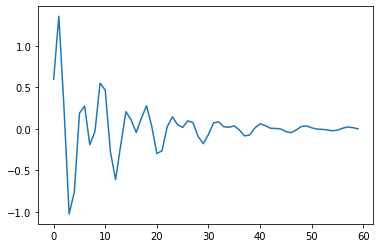

In [11]:
# a, d, T, phi
params = [1., 8, 4.3, -np.pi/2]
params += [.6, 11.1, 8.2, -.1]
# params += [.4, 12, 5, .2]
params = np.array(params).reshape(-1, 4).T
pretty_print_hrparams(*params)
N = 60
h_test = h_model(N, *params)
plt.plot(h_test)
plt.show()

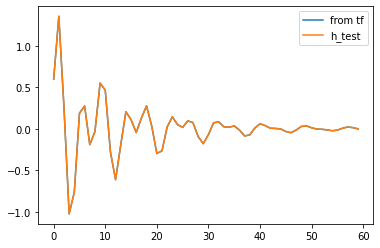

In [13]:
b, a = hr2tf(*params)
%matplotlib inline
ir = tf2ir(b, a, N)
plt.plot(ir, label='from tf')
plt.plot(h_test, label='h_test')
plt.legend()
plt.show()